# PCA Analysis of Omics Datasets

In this notebook I will attempt to recreate the results found in the paper, where the modality of each dataset was determined by the number of principle components necessary to capture 90% of the variation within the dataset. The authors concluded that the modality was not correlated with number of measurements.

I will perform this analysis both on the raw data, and the data that I cleaned (removed duplicate columns) as the authors did not specify at what stage of data cleansing they performed.

## Loading Data

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import pickle
def load_obj(name ):                    
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Raw Data

In [3]:
filenames = ['cellfreerna.csv','plasmaluminex.csv','serumluminex.csv','microbiome.csv','immunesystem.csv','metabolomics.csv','plasmasomalogic.csv']

In [4]:
datasets = {}
for file in filenames:
    data = pd.read_csv(file)
    data.rename(columns={'Unnamed: 0':'PatientID'},inplace=True)
    data = data.set_index('PatientID', drop=True)
    if 'response' not in datasets.keys():
        datasets['response'] = data.featureweeks
    data = data.drop('featureweeks', axis=1)
    datasets[file[0:file.find('.')]] = data
    print('Successfully loaded the', file[0:file.find('.')], 'dataset' )

Successfully loaded the cellfreerna dataset
Successfully loaded the plasmaluminex dataset
Successfully loaded the serumluminex dataset
Successfully loaded the microbiome dataset
Successfully loaded the immunesystem dataset
Successfully loaded the metabolomics dataset
Successfully loaded the plasmasomalogic dataset


In [5]:
def scaleFeatures(data):
    '''
    data: pandas DataFrame object
    Returns the scaled (subtract mean vector and then by SD) pandas DataFrame object inputted
    '''
    for feature in data.columns:
        if data[feature].std() != 0: #avoid division by 0
            data[feature] = (data[feature] - data[feature].mean())/data[feature].std() #subtract column mean and divide by standard deviation
    return data

Above is a function for scaling the data, which will be done before PCA as to not let different scales inflate importance.

In [6]:
def numberOfPCs(data, name = 'dataset', svd_solver = 'auto'):
    '''
    data: pandas DataFrame object
    name: (Optional) Allows the name of the pandas DataFrame object to be printed
    Returns a list with the amount of variation explained, and the number of PCs needed
    '''
    num = 1
    var = 0
    while var < 0.90:
        pca = PCA(num, svd_solver= svd_solver)
        pca.fit(data)
        var = sum(pca.explained_variance_ratio_)
        num +=1
    print('You need', num-1, 'Principle Components to explain > 90% of the variation in the', name, 'dataset.')
    print('These principle components capture', sum(pca.explained_variance_ratio_), 'percent of the variation within the', name, 'data')
    print('\n')
    return([sum(pca.explained_variance_ratio_), num-1])

Above is a function that returns the number of Principle Components required to capture 90% of the variation within the data, along with the amount of variation captured by those principle components.

In [7]:
numberOfComponents_raw = {}
for data in datasets:
    if data != 'response':
        numberOfComponents_raw[data] = numberOfPCs(scaleFeatures(datasets[data]), data)

You need 46 Principle Components to explain > 90% of the variation in the cellfreerna dataset.
These principle components capture 0.909986191184654 percent of the variation within the cellfreerna data


You need 10 Principle Components to explain > 90% of the variation in the plasmaluminex dataset.
These principle components capture 0.9110325607914824 percent of the variation within the plasmaluminex data


You need 9 Principle Components to explain > 90% of the variation in the serumluminex dataset.
These principle components capture 0.9090523859198166 percent of the variation within the serumluminex data


You need 1 Principle Components to explain > 90% of the variation in the microbiome dataset.
These principle components capture 0.9321384143712371 percent of the variation within the microbiome data


You need 22 Principle Components to explain > 90% of the variation in the immunesystem dataset.
These principle components capture 0.9033477920635484 percent of the variation within t

Above I iterate through each dataset, and capture the number of PC's required to capture 90% of the variance in the raw dataset.

## Cleaned Data

Let's repeat the above steps below:

In [8]:
datasets_cleaned = load_obj('datasets_cleaned')

In [9]:
numberOfComponents_cleaned = {}
for data in datasets_cleaned:
    numberOfComponents_cleaned[data] = numberOfPCs(scaleFeatures(datasets_cleaned[data]), data)

You need 42 Principle Components to explain > 90% of the variation in the cellfreerna dataset.
These principle components capture 0.9072989796114417 percent of the variation within the cellfreerna data


You need 10 Principle Components to explain > 90% of the variation in the plasmaluminex dataset.
These principle components capture 0.9110325607914824 percent of the variation within the plasmaluminex data


You need 9 Principle Components to explain > 90% of the variation in the serumluminex dataset.
These principle components capture 0.9090523859198166 percent of the variation within the serumluminex data


You need 8 Principle Components to explain > 90% of the variation in the microbiome dataset.
These principle components capture 0.9046211441846763 percent of the variation within the microbiome data


You need 22 Principle Components to explain > 90% of the variation in the immunesystem dataset.
These principle components capture 0.9039141932716487 percent of the variation within 

## Visualization

In [10]:
plt.rcParams['figure.figsize']=(5,5)
plt.rcParams["axes.labelsize"] = 15

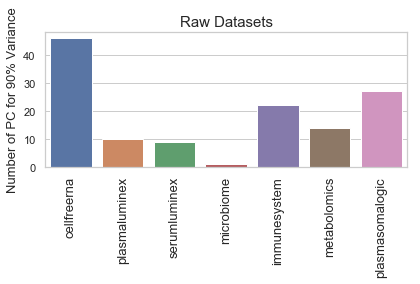

In [11]:
sns.set(style="whitegrid")
names = list(numberOfComponents_cleaned.keys())
ax = sns.barplot(x=names, y=[numberOfComponents_raw[x][1] for x in numberOfComponents_raw.keys()])
plt.title('Raw Datasets',fontsize=15)
plt.ylabel('Number of PC for 90% Variance',fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('RawPCA')

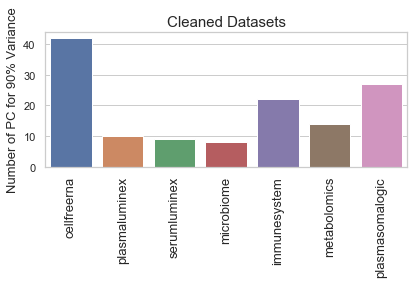

In [12]:
sns.set(style="whitegrid")
names = list(numberOfComponents_cleaned.keys())
ax = sns.barplot(x=names, y=[numberOfComponents_cleaned[x][1] for x in numberOfComponents_cleaned.keys()])
plt.title('Cleaned Datasets', fontsize=15)
plt.ylabel('Number of PC for 90% Variance', fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('CleanedPCA')

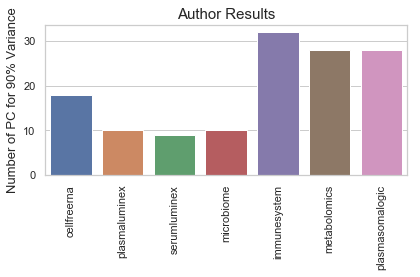

In [13]:
ax = sns.barplot(x=names, y=[18,10,9,10,32,28,28]) #estimated by hand
plt.xticks(rotation=90)
plt.title('Author Results', fontsize=15)
plt.ylabel('Number of PC for 90% Variance', fontsize=13)
plt.tight_layout()

Looking above both of my graphs for the number of PCs to account of 90% of the data look different. While cleaning the data (removing duplicate columns) did make things slightly more similar by bringing up the number for the microbiome dataset, several values are drastically different, such as the number for the cellfreerna dataset.

Now I will recreate the graph of number of available measurements per dataset. These will only differ in terms of the cellfreerna dataset and the microbiome dataset, as those are the only datasets where columns were removed.

In [14]:
numMeasurements_Raw = []
for name, data in datasets.items():
    if name == 'response':
        continue     
    numMeasurements_Raw.append(data.shape[1])
    
numMeasurements_Cleaned = []
for name, data in datasets_cleaned.items():
    if name == 'response':
        continue
    numMeasurements_Cleaned.append(data.shape[1])
    

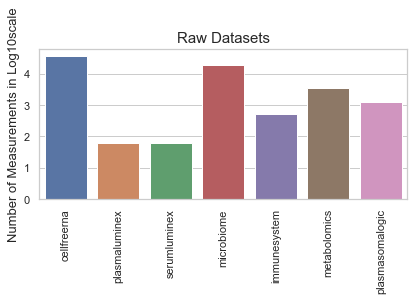

In [20]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=np.log10(numMeasurements_Raw))
plt.title('Raw Datasets', fontsize=15)
plt.ylabel('Number of Measurements in Log10scale', fontsize=13)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('rawdatasetscounts')

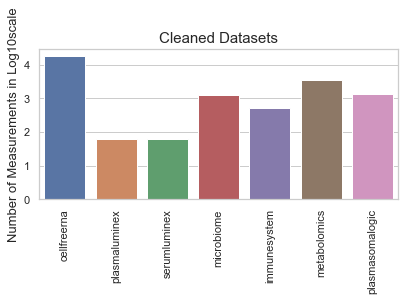

In [22]:
sns.set(style="whitegrid")
ax = sns.barplot(x=names, y=np.log10(numMeasurements_Cleaned))
plt.title('Cleaned Datasets', fontsize=15)
plt.ylabel('Number of Measurements in Log10scale', fontsize=13)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('cleaneddatasetscounts')

Looking above the graph for number of measurements for the raw datasets seems to most closely parallel the authors results (see Fig 1C in the paper), which could suggest they made these counts with the raw data. Thus either they calculated the measurements/PCs at different stages, or our PCA analyses differ greatly in terms of underlying implementation.